# Compare song->neural->mtn predictions conditioned on strain

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys

from aux import load_npy
from disp import set_plot
from my_torch import skl_fit_ridge

cc = np.concatenate

NSPLIT = 30
STRAIN_FILE = 'data/simple/strains.csv'

FIT_KWARGS = {'alpha': 10}

TWDWS = [.03, 1, 60]
NSPLIT_SAVE_Y_HAT = 3

In [2]:
NRL_MDL = 'ma'  # mult-adapt neural model

DF_BAKER_FIT_PARAM = pd.read_csv(f'data/simple/neur/baker_{NRL_MDL}_fit_param.csv')

DF_STRAIN = pd.read_csv(STRAIN_FILE)
STRAINS = np.array(DF_STRAIN['STRAIN'])
STRAINS_UNIQUE = np.unique(STRAINS)

STRAIN_COMBOS = [('NM91', 'ZH23'), ('NM91', 'CarM03'), ('ZH23', 'CarM03'), ('NM91', 'ZH23', 'CarM03')]
COMBO_KEYS = ['_'.join([strain.lower() for strain in strain_combo]) for strain_combo in STRAIN_COMBOS]

R_COLS_USE = [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID]

TARG_BHV = 'MTN'
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_NRL = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}/mlv_baker_{NRL_MDL}'
PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

print('Strains:', STRAINS_UNIQUE)

Strains: ['CM07' 'CSTul' 'CarM03' 'N30' 'NM91' 'WTG' 'ZH23' 'ZW109']


### Individual strains

In [ ]:
for strain in STRAINS_UNIQUE:
    itr_strain = np.arange(len(STRAINS))[STRAINS == strain]
    ntr = len(itr_strain)
    print(f'\nStrain {strain}: {ntr} trials: {itr_strain}')
    
    save_file = f'data/simple/mlv/neur_basic/by_strain/baker_{NRL_MDL}_{strain.lower()}_{TARG_BHV.lower()}.npy'
    
    ntrain = int(round(.8*ntr))

    # fit regression models
    rslts = skl_fit_ridge(
        [PFX_NRL, PFX_BHV], R_COLS_USE, TARGS,
        itr_strain, ntrain, NSPLIT,
        return_y=np.arange(NSPLIT_SAVE_Y_HAT), **FIT_KWARGS)
    
    # save r2, weights, and example predictions
    save_data = {
        'r2_train': {targ: np.array([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS},
        'r2_test': {targ: np.array([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS},
        'w': {targ: np.array([rslt.w[targ] for rslt in rslts]) for targ in TARGS},
        
        'ys_train': {targ: [rslt.ys_train[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
        'y_hats_train': {targ: [rslt.y_hats_train[targ] for rslt in rslts if rslt.y_hats_train] for targ in TARGS},
        
        'ys_test': {targ: [rslt.ys_test[targ] for rslt in rslts if rslt.ys_test] for targ in TARGS},
        'y_hats_test': {targ: [rslt.y_hats_test[targ] for rslt in rslts if rslt.y_hats_test] for targ in TARGS},
        
        'targs': TARGS,
        'strain': strain,
        
        'ntr': ntr,
        'ntrain': ntrain,
        'nsplit': NSPLIT,
        
        'nr': len(R_COLS_USE)
    }

    np.save(save_file, np.array([save_data]))

### Combined strains

In [ ]:
for strain_combo, combo_key in zip(STRAIN_COMBOS, COMBO_KEYS):
    itr_strain = cc([np.arange(len(STRAINS))[STRAINS == strain] for strain in strain_combo])
    
    ntr = len(itr_strain)
    print(f'\nStrains {combo_key}: {ntr} trials: {itr_strain}')
    
    save_file = f'data/simple/mlv/neur_basic/by_strain/baker_{NRL_MDL}_{combo_key}_{TARG_BHV.lower()}.npy'
    
    ntrain = int(round(.8*ntr))

    # fit regression models
    rslts = skl_fit_ridge(
        [PFX_NRL, PFX_BHV], R_COLS_USE, TARGS,
        itr_strain, ntrain, NSPLIT,
        return_y=np.arange(NSPLIT_SAVE_Y_HAT), **FIT_KWARGS)
    
    # save r2, weights, and example predictions
    save_data = {
        'r2_train': {targ: np.array([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS},
        'r2_test': {targ: np.array([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS},
        'w': {targ: np.array([rslt.w[targ] for rslt in rslts]) for targ in TARGS},
        
        'ys_train': {targ: [rslt.ys_train[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
        'y_hats_train': {targ: [rslt.y_hats_train[targ] for rslt in rslts if rslt.y_hats_train] for targ in TARGS},
        
        'ys_test': {targ: [rslt.ys_test[targ] for rslt in rslts if rslt.ys_test] for targ in TARGS},
        'y_hats_test': {targ: [rslt.y_hats_test[targ] for rslt in rslts if rslt.y_hats_test] for targ in TARGS},
        
        'targs': TARGS,
        'strain': combo_key,
        
        'ntr': ntr,
        'ntrain': ntrain,
        'nsplit': NSPLIT,
        
        'nr': len(R_COLS_USE)
    }

    np.save(save_file, np.array([save_data]))

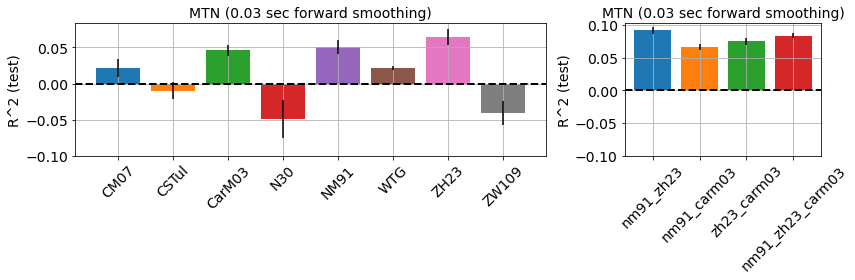

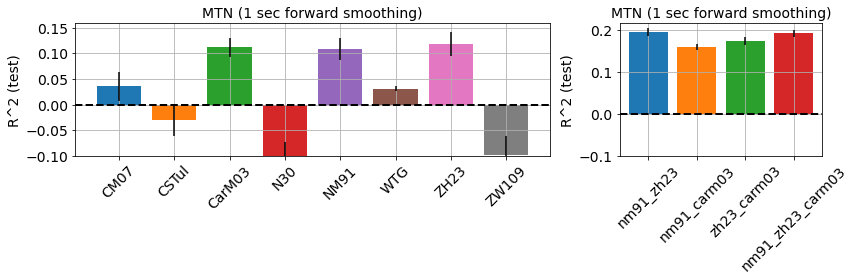

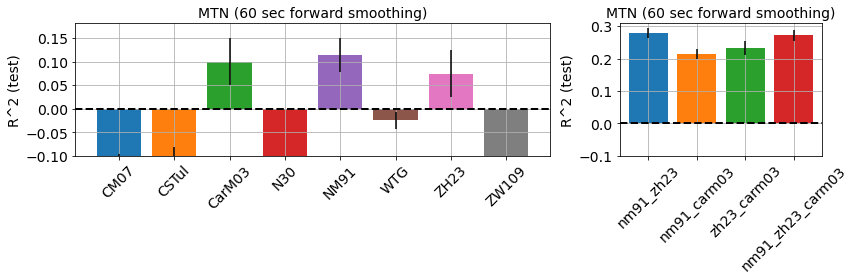

In [3]:
for targ, twdw in zip(TARGS, TWDWS):
    
    gs = gridspec.GridSpec(1, 3)
    fig = plt.figure(figsize=(12, 4), tight_layout=True)
    axs = [fig.add_subplot(gs[0, :2]), fig.add_subplot(gs[0, 2])]

    for ax, strain_keys in zip(axs, [STRAINS_UNIQUE, COMBO_KEYS]):

        for ckey, key in enumerate(strain_keys):
            ax = axs[0] if key in STRAINS_UNIQUE else axs[1]

            try:
                data = load_npy(f'data/simple/mlv/neur_basic/by_strain/baker_{NRL_MDL}_{key.lower()}_{TARG_BHV.lower()}.npy')

                r2_mn = data['r2_test'][targ].mean()
                r2_std = data['r2_test'][targ].std()
                r2_sem = r2_std/np.sqrt(data['nsplit'])

                ax.bar([ckey], [r2_mn], yerr=[r2_sem])
                
            except Exception as e:
                print(e)
                ax.scatter([ckey], 0, marker='x', s=100, c='k')

        ax.axhline(0, lw=2, c='k', ls='--')
        ax.set_xticks(np.arange(len(strain_keys)))
        ax.set_xticklabels(strain_keys, rotation=45)
        
        ax.set_ylim(bottom=-.1)

        ax.grid()

        set_plot(ax, y_label='R^2 (test)', title=f'{TARG_BHV} ({twdw} sec forward smoothing)', font_size=14)